# Imports

In [1]:
import glob
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data

In [2]:
data_folder = osp.join("..", "data", "processed")

for i, fpath in enumerate(glob.glob(osp.join(data_folder, "*.csv"))):
    if i == 0:
        df = pd.read_csv(fpath)
    else:
        df_i = pd.read_csv(fpath)
        df = pd.concat([df, df_i])

df["time"] = pd.to_datetime(df["time"])
df = df.set_index("time")
        
print(df.shape)
df.head()

(214074, 4)


,source_name,total,left,right
time,,,,
2021-01-09 21:49:59,gostiny,18,5,13
2021-01-09 21:50:01,anichkov,14,3,11
2021-01-09 21:50:03,slavy,1,0,1
2021-01-09 21:50:05,gostiny,12,1,11
2021-01-09 21:50:07,anichkov,11,2,9


# Data with scans

In [3]:
scans = pd.DataFrame({
    "time": ["2021-01-12 08:49:26", "2021-01-12 11:05:10", "2021-01-12 11:07:25"],
    "scans": [1, 1, 1]
})
scans["time"] = pd.to_datetime(scans["time"])
scans.set_index("time", inplace=True)
scans_15s = scans.groupby(pd.Grouper(freq="15s")).max()
scans_15s.head()

,scans
time,
2021-01-12 08:49:15,1.0
2021-01-12 08:49:30,NaN
2021-01-12 08:49:45,NaN
2021-01-12 08:50:00,NaN
2021-01-12 08:50:15,NaN


# Analyze data

In [4]:
df_15s = df.groupby(["source_name", pd.Grouper(freq='15s')]).min().reset_index("source_name")

In [5]:
df_total = df_15s.merge(scans_15s, left_index=True, right_index=True, how="outer")
print(df_total.shape)
df_total.head()

(88265, 5)


,source_name,total,left,right,scans
time,,,,,
2021-01-09 21:31:30,anichkov,15,2,13,NaN
2021-01-09 21:31:30,gostiny,12,1,11,NaN
2021-01-09 21:31:45,anichkov,10,0,10,NaN
2021-01-09 21:31:45,gostiny,14,0,12,NaN
2021-01-09 21:31:45,slavy,0,0,0,NaN


(94, 2)


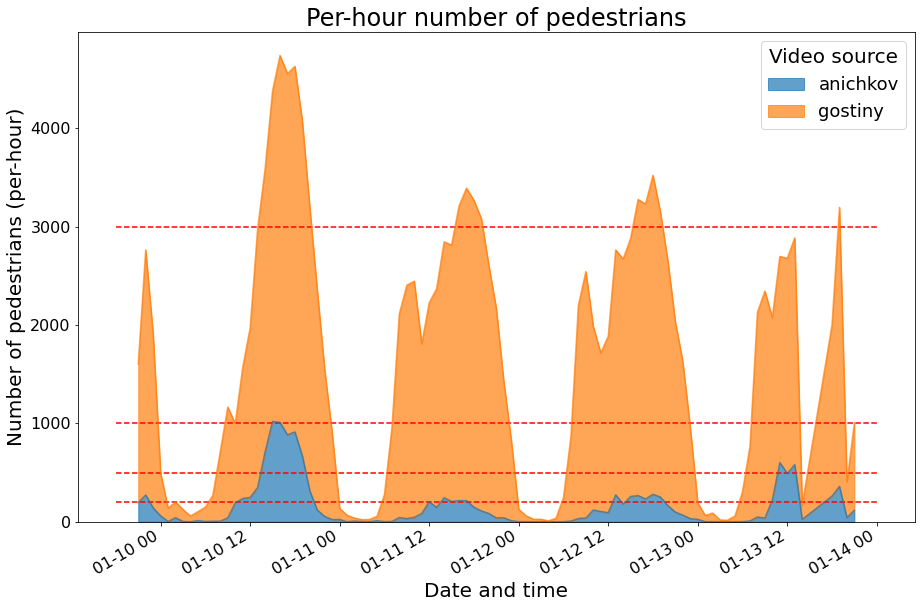

In [20]:
df_1h = df_total[(df_total.index < pd.to_datetime("2021-01-14")) & (df_total["source_name"] != "slavy")]\
    .groupby(["source_name", pd.Grouper(freq="H")]).sum().reset_index("source_name")

df_1h["values"] = df_1h[["source_name", "total", "left"]].apply(lambda x: x[2] if x[0] == "anichkov" else x[1], axis=1)

fig, ax = plt.subplots(figsize=(15, 10))
pivot = pd.pivot_table(df_1h, values="values", index="time", columns="source_name")
print(pivot.shape)

pivot.plot(kind="area", alpha=0.7, ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date and time", fontsize=20)
plt.ylabel("Number of pedestrians (per-hour)", fontsize=20)
plt.legend(title="Video source", fontsize=18, title_fontsize=20)

plt.hlines([200, 500, 1000, 3000], xmin=pd.to_datetime("2021-01-09 18:00"), xmax=pd.to_datetime("2021-01-14"), linestyles="dashed", color="red", )

# ax2 = ax.twinx()
# ax2.yaxis.set_tick_params(labelsize=16)
# ax2.set_ylabel("Scans (per hour)", fontsize=20)
# scan = df_1h[df_1h["source_name"] == "gostiny"]["scans"]
# scan[scan == 0] = np.nan
# ax2.bar(scan.index, scan.values, color="violet", width=0.1, alpha=0.5)

plt.title("Per-hour number of pedestrians", fontsize=24);

(94, 2)


/home/glyc/.virtualenvs/algo/lib/python3.6/site-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


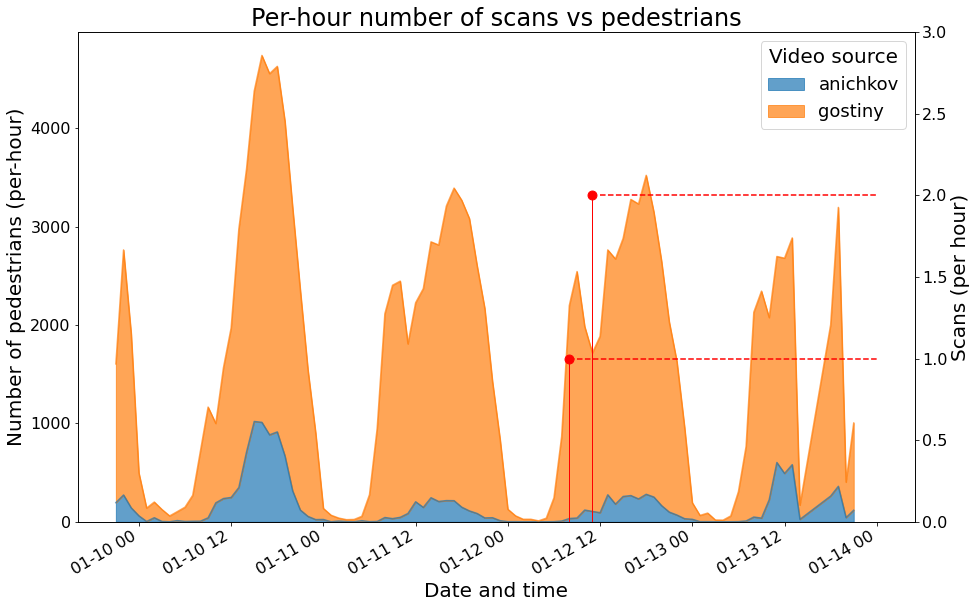

In [46]:
df_1h = df_total[(df_total.index < pd.to_datetime("2021-01-14")) & (df_total["source_name"] != "slavy")]\
    .groupby(["source_name", pd.Grouper(freq="H")]).sum().reset_index("source_name")

df_1h["values"] = df_1h[["source_name", "total", "left"]].apply(lambda x: x[2] if x[0] == "anichkov" else x[1], axis=1)

fig, ax = plt.subplots(figsize=(15, 10))
pivot = pd.pivot_table(df_1h, values="values", index="time", columns="source_name")
print(pivot.shape)

pivot.plot(kind="area", alpha=0.7, ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date and time", fontsize=20)
plt.ylabel("Number of pedestrians (per-hour)", fontsize=20)
plt.legend(title="Video source", fontsize=18, title_fontsize=20)

ax2 = ax.twinx()
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("Scans (per hour)", fontsize=20)
scan = df_1h[df_1h["source_name"] == "gostiny"]["scans"]
scan[scan == 0] = np.nan
ax2.scatter(scan.index, scan.values, color="red", s=80)
ax2.fill_between(scan.index, scan.values, color="red")
ax2.hlines([1.0], xmin=pd.to_datetime("2021-01-12 08:00"), xmax=pd.to_datetime("2021-01-14"), color="red", linestyles="dashed")
ax2.hlines([2.0], xmin=pd.to_datetime("2021-01-12 12:00"), xmax=pd.to_datetime("2021-01-14"), color="red", linestyles="dashed")
ax2.set_ylim([0.0, 3.0])

plt.title("Per-hour number of scans vs pedestrians", fontsize=24);